Marcin Grzyb marcingrzyb@student.agh.edu.pl 
Paweł Gałka pawelgalka@student.agh.edu.pl

In [1]:
!git clone https://github.com/marcingrzyb/computational-intelligence-data.git

Cloning into 'computational-intelligence-data'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [0]:
import tensorflow.keras


In [3]:
from pandas import read_csv
from sklearn.model_selection import train_test_split

dataset=read_csv('/content/computational-intelligence-data/project3/Bias_correction_ucl.csv',header=0)
print(dataset.shape)
#dropping station and date columns
dataset.drop('station', axis=1, inplace=True)
dataset.drop('Date', axis=1, inplace=True)
print(dataset.shape)

#deleting NaN values
dataset.dropna(inplace=True)
print(dataset.shape)

#popping columns with result values
tmax=dataset.pop('Next_Tmax')
tmin=dataset.pop('Next_Tmin')
print(dataset.shape)

X_train, X_test, y_train, y_test = train_test_split(dataset,tmax, test_size=0.33, random_state=42)#to predict Tmin column, change tmax to tmin

mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std


(7752, 25)
(7752, 23)
(7590, 23)
(7590, 21)


In [0]:
#create validation set from train Max
X_train, X_ValidationMax, y_train, y_ValidationMax = train_test_split(X_train,y_train, test_size=0.33, random_state=42)

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(X_ValidationMax.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model

In [0]:
from tensorflow.keras import backend as K

# Some memory clean-up
K.clear_session()

In [7]:
import numpy as np

k = 5
num_epochs=50
num_val_samples = len(X_ValidationMax) // k
all_scores = []
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  # Prepare the validation data: data from partition # k
  val_data = X_ValidationMax[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = y_ValidationMax[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepare the training data: data from all other partitions
  partial_train_data = np.concatenate(
      [X_ValidationMax[:i * num_val_samples],
      X_ValidationMax[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [y_ValidationMax[:i * num_val_samples],
      y_ValidationMax[(i + 1) * num_val_samples:]],
      axis=0)

  # Build the Keras model (already compiled)
  model = build_model()
  # Train the model (in silent mode, verbose=0)
  history=model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=1)
  # Evaluate the model on the validation data
  print(history.history.keys())
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
  all_scores.append(val_mae)
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)


processing fold # 0
Epoch 1/50
1344/1344 [==============================] - 2s 1ms/step - loss: 78.5707 - mean_absolute_error: 5.5784
Epoch 2/50
1344/1344 [==============================] - 2s 1ms/step - loss: 9.5293 - mean_absolute_error: 2.3479
Epoch 3/50
1344/1344 [==============================] - 2s 1ms/step - loss: 6.8487 - mean_absolute_error: 1.9601
Epoch 4/50
1344/1344 [==============================] - 2s 1ms/step - loss: 6.0453 - mean_absolute_error: 1.7817
Epoch 5/50
1344/1344 [==============================] - 2s 1ms/step - loss: 4.9591 - mean_absolute_error: 1.6097
Epoch 6/50
1344/1344 [==============================] - 2s 1ms/step - loss: 4.8013 - mean_absolute_error: 1.5686
Epoch 7/50
1344/1344 [==============================] - 2s 1ms/step - loss: 4.2858 - mean_absolute_error: 1.4805
Epoch 8/50
1344/1344 [==============================] - 2s 1ms/step - loss: 3.9902 - mean_absolute_error: 1.4047
Epoch 9/50
1344/1344 [==============================] - 2s 1ms/step - loss:

In [8]:
print(np.mean(all_scores))
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

1.1462229490280151


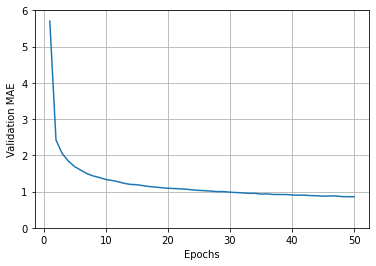

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.ylim(0,6)
plt.show()

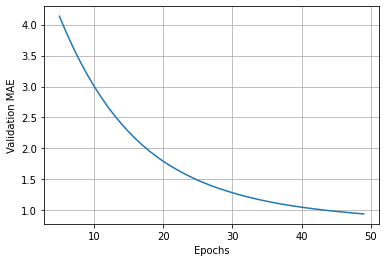

In [12]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(5, len(smooth_mae_history) ), smooth_mae_history[5:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid()
plt.show()

In [11]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(X_train, y_train,
          epochs=50, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 1ms/step - loss: 1.6540 - mean_absolute_error: 1.0061
